# Twitch-Only Embeddings Tasks

This notebook contains only the tasks related to the Twitch PTBR dataset from embeddings_notebook.ipynb.
It includes:
- data download and extraction,
- graph loading and summary statistics,
- Spectral vs Node2Vec embedding visualization,
- downstream node classification evaluation.


In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.sparse as sp
import os
import urllib.request
import shutil
import zipfile

from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from node2vec import Node2Vec as N2V_Algo

import warnings
warnings.filterwarnings('ignore')


c:\Users\stef4\Desktop\Massive Graph\community_detection\.graph_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_twitch_data():
    os.makedirs("data", exist_ok=True)
    target_dir = os.path.join("data", "twitch")
    os.makedirs(target_dir, exist_ok=True)

    base_url = "https://github.com/Carda01/community_detection/releases/download/1.0/"
    fname = "twitch_data.zip"
    url = base_url + fname
    dest_zip = os.path.join(target_dir, fname)

    print(f"Downloading {fname}...")
    urllib.request.urlretrieve(url, dest_zip)

    print(f"Extracting PTBR files from {fname}...")
    with zipfile.ZipFile(dest_zip, 'r') as z:
        for member in z.namelist():
            if member.startswith("__MACOSX/") or os.path.basename(member).startswith("._"):
                continue

            for target_file in ["musae_PTBR_edges.csv", "musae_PTBR_target.csv"]:
                if member.endswith(target_file):
                    print(f"Extracting {member}...")
                    source = z.open(member)
                    dest_path = os.path.join(target_dir, target_file)
                    with open(dest_path, "wb") as f_out:
                        shutil.copyfileobj(source, f_out)

    print("Twitch PTBR files downloaded and extracted successfully.")


download_twitch_data()


Extracting PTBR files from twitch_data.zip...
Extracting twitch_data/musae_PTBR_target.csv...
Extracting twitch_data/musae_PTBR_edges.csv...
Twitch PTBR files downloaded and extracted successfully.


In [3]:
def load_twitch_robust():
    print("--- Loading Twitch Data (Robust Method) ---")

    df_edges = pd.read_csv("data/twitch/musae_PTBR_edges.csv")
    G = nx.from_pandas_edgelist(df_edges, source='from', target='to')

    df_targets = pd.read_csv("data/twitch/musae_PTBR_target.csv")

    attr_dict = {}
    for _, row in df_targets.iterrows():
        node_id = int(row['new_id'])
        is_mature = 1 if row['mature'] == True else 0
        is_partner = 1 if row['partner'] == True else 0

        attr_dict[node_id] = {
            "days": row['days'],
            "views": row['views'],
            "partner": is_partner,
            "twitch_partner": is_partner,
            "mature": is_mature
        }

    nx.set_node_attributes(G, attr_dict)

    valid_nodes = set(attr_dict.keys())
    nodes_to_remove = [n for n in G.nodes() if n not in valid_nodes]
    if nodes_to_remove:
        print(f"Removing {len(nodes_to_remove)} nodes without attributes.")
        G.remove_nodes_from(nodes_to_remove)

    return G


def summary_stats(graph):
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")

    degrees = [d for _, d in graph.degree()]
    avg_degree = sum(degrees) / graph.number_of_nodes()
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Density: {nx.density(graph):.4f}")

    if nx.is_connected(graph):
        print("Graph is connected.")
    else:
        num_components = nx.number_connected_components(graph)
        print(f"Graph is not connected. It has {num_components} connected components.")
        largest_cc = max(nx.connected_components(graph), key=len)
        print(f"Largest Component Size: {len(largest_cc)} nodes")


print("--- Loading Twitch Graph ---")
G_twitch = load_twitch_robust()
summary_stats(G_twitch)


--- Loading Twitch Graph ---
--- Loading Twitch Data (Robust Method) ---
Number of nodes: 1912
Number of edges: 31299
Average degree: 32.74
Density: 0.0171
Graph is connected.


### Spectral Embedding vs Node2Vec on Twitch

- Spectral Embedding: Laplacian Eigenmaps over the graph adjacency.
- Node2Vec: biased random walks with Skip-Gram.



=== Running Analysis for Twitch PTBR (Target Attribute: mature) ===
   > Computing Spectral Embedding (d=32)...
   > Computing Node2Vec Embedding (d=32, p=1.0, q=0.5)...
   > Projecting to 2D using t-SNE for Twitch PTBR (Target Attribute: mature)...


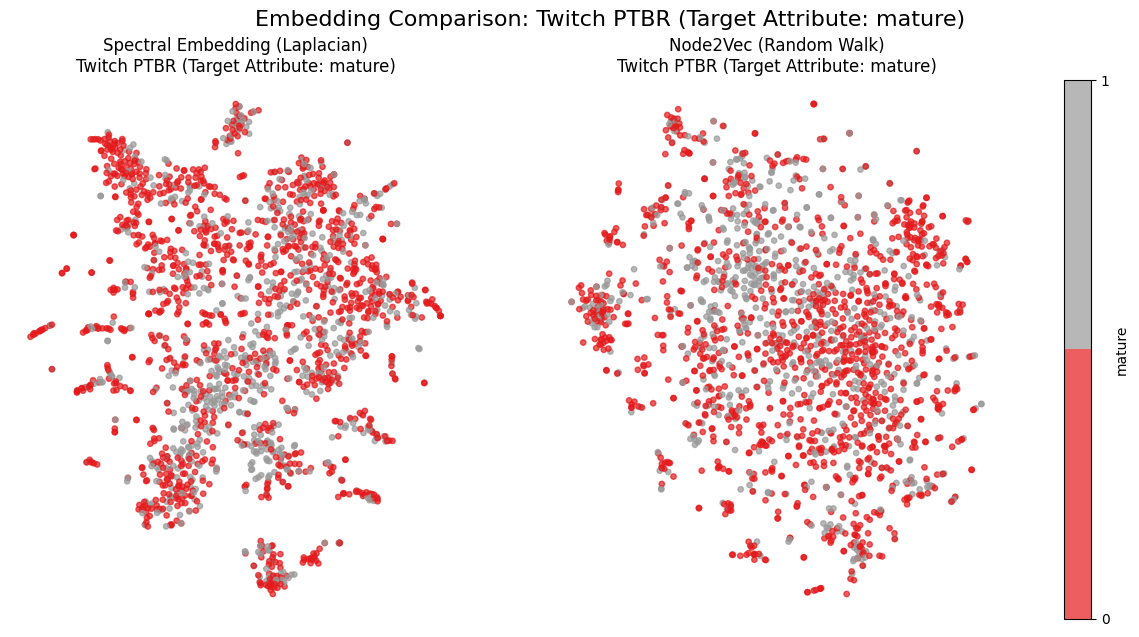

   > Projecting to 2D using t-SNE for Twitch PTBR (Target Attribute: twitch_partner)...


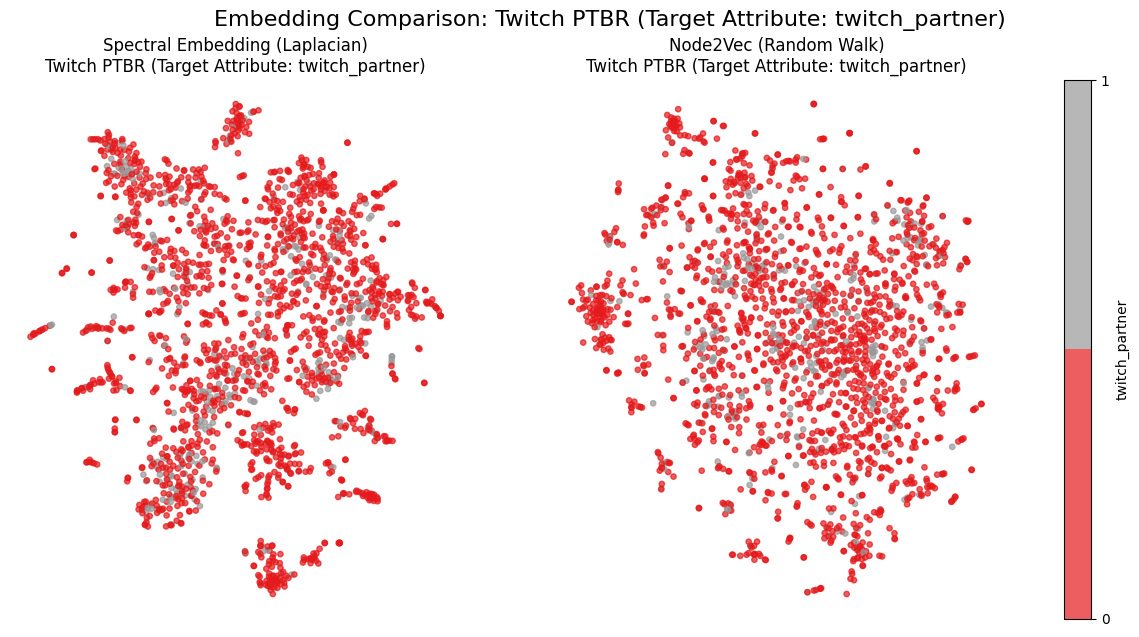

In [4]:
def get_spectral_embedding(G, dim=16, seed=42):
    print(f"   > Computing Spectral Embedding (d={dim})...")
    adj = nx.to_scipy_sparse_array(G, format='csr', dtype=np.float64)
    adj = sp.csr_matrix(adj)
    adj.indices = adj.indices.astype(np.int32, copy=False)
    adj.indptr = adj.indptr.astype(np.int32, copy=False)
    se = SpectralEmbedding(n_components=dim, affinity='precomputed', random_state=seed)
    embeddings = se.fit_transform(adj)
    return embeddings


def get_node2vec_embedding(G, dim=16, p=1.0, q=1.0, walks=10, length=80, seed=42):
    print(f"   > Computing Node2Vec Embedding (d={dim}, p={p}, q={q})...")
    node2vec_model = N2V_Algo(
        G,
        dimensions=dim,
        walk_length=length,
        num_walks=walks,
        p=p,
        q=q,
        workers=1,
        quiet=True,
        seed=seed,
    )
    model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

    nodes = list(G.nodes())
    embeddings = np.array([model.wv[str(n)] for n in nodes])
    return embeddings


def visualize_embeddings_side_by_side(G, emb_spectral, emb_n2v, title_prefix, target_attr='mature'):
    nodes = list(G.nodes())
    labels = [G.nodes[n].get(target_attr) for n in nodes]
    binary_cmap = plt.cm.get_cmap('Set1', 2)

    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')

    print(f"   > Projecting to 2D using t-SNE for {title_prefix}...")
    vis_spectral = tsne.fit_transform(emb_spectral)
    vis_n2v = tsne.fit_transform(emb_n2v)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    sc1 = axes[0].scatter(vis_spectral[:, 0], vis_spectral[:, 1], c=labels, cmap=binary_cmap, vmin=0, vmax=1, s=15, alpha=0.7)
    axes[0].set_title(f"Spectral Embedding (Laplacian)\n{title_prefix}")
    axes[0].axis('off')

    sc2 = axes[1].scatter(vis_n2v[:, 0], vis_n2v[:, 1], c=labels, cmap=binary_cmap, vmin=0, vmax=1, s=15, alpha=0.7)
    axes[1].set_title(f"Node2Vec (Random Walk)\n{title_prefix}")
    axes[1].axis('off')

    plt.suptitle(f"Embedding Comparison: {title_prefix}", fontsize=16)

    cbar = plt.colorbar(sc2, ax=axes.ravel().tolist(), ticks=[0, 1])
    cbar.set_label(target_attr)
    cbar.set_ticklabels(['0', '1'])

    plt.show()


def run_embedding_analysis(G, name, target_attr, p=1.0, q=1.0):
    print(f"\n=== Running Analysis for {name} ===")
    emb_spec = get_spectral_embedding(G, dim=32)
    emb_n2v = get_node2vec_embedding(G, dim=32, p=p, q=q)
    visualize_embeddings_side_by_side(G, emb_spec, emb_n2v, name, target_attr)
    return emb_spec, emb_n2v


emb_twitch_spec, emb_twitch_n2v = run_embedding_analysis(
    G_twitch,
    name="Twitch PTBR (Target Attribute: mature)",
    target_attr="mature",
    p=1.0,
    q=0.5,
)

visualize_embeddings_side_by_side(
    G_twitch,
    emb_twitch_spec,
    emb_twitch_n2v,
    title_prefix="Twitch PTBR (Target Attribute: twitch_partner)",
    target_attr="twitch_partner",
)



=== Downstream Task: Node Attribute Classification (Twitch PTBR) ===
--- Evaluating Spectral on Twitch PTBR ---
   > Accuracy: 0.8642
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       331
           1       0.00      0.00      0.00        52

    accuracy                           0.86       383
   macro avg       0.43      0.50      0.46       383
weighted avg       0.75      0.86      0.80       383

--- Evaluating Node2Vec on Twitch PTBR ---
   > Accuracy: 0.8877
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       331
           1       0.63      0.42      0.51        52

    accuracy                           0.89       383
   macro avg       0.77      0.69      0.72       383
weighted avg       0.88      0.89      0.88       383



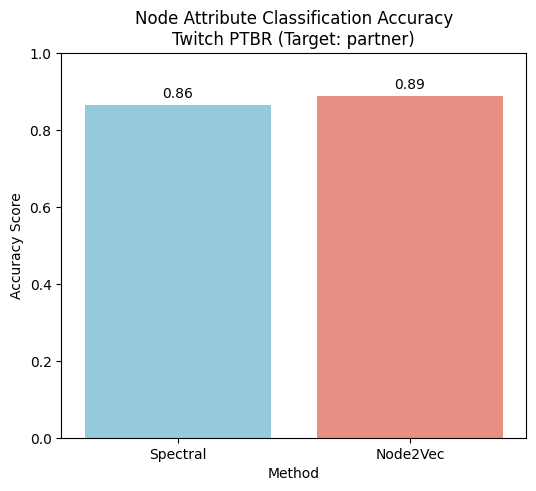


=== Downstream Task: Node Attribute Classification (Twitch PTBR) ===
--- Evaluating Spectral on Twitch PTBR ---
   > Accuracy: 0.6789
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       260
           1       0.00      0.00      0.00       123

    accuracy                           0.68       383
   macro avg       0.34      0.50      0.40       383
weighted avg       0.46      0.68      0.55       383

--- Evaluating Node2Vec on Twitch PTBR ---
   > Accuracy: 0.7128
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       260
           1       0.60      0.32      0.41       123

    accuracy                           0.71       383
   macro avg       0.67      0.61      0.61       383
weighted avg       0.69      0.71      0.68       383



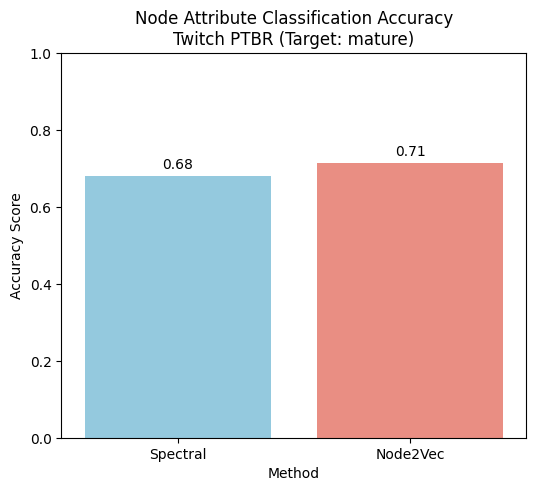

In [5]:
def evaluate_embeddings(G, embeddings, target_attr, name, method_name):
    print(f"--- Evaluating {method_name} on {name} ---")

    nodes = list(G.nodes())
    y = []
    valid_indices = []

    for i, node in enumerate(nodes):
        label = G.nodes[node].get(target_attr)
        if label is not None:
            y.append(label)
            valid_indices.append(i)

    X = embeddings[valid_indices]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"   > Accuracy: {acc:.4f}")
    if len(set(y)) < 10:
        print(classification_report(y_test, y_pred, zero_division=0))

    return acc


def compare_downstream_tasks(G, emb_spec, emb_n2v, name, target_attr):
    print(f"\n=== Downstream Task: Node Attribute Classification ({name}) ===")

    score_spec = evaluate_embeddings(G, emb_spec, target_attr, name, "Spectral")
    score_n2v = evaluate_embeddings(G, emb_n2v, target_attr, name, "Node2Vec")

    results = pd.DataFrame(
        {
            'Method': ['Spectral', 'Node2Vec'],
            'Accuracy': [score_spec, score_n2v],
        }
    )

    plt.figure(figsize=(6, 5))
    sns.barplot(data=results, x='Method', y='Accuracy', palette=['skyblue', 'salmon'])
    plt.title(f"Node Attribute Classification Accuracy\n{name} (Target: {target_attr})")
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy Score")

    for index, row in results.iterrows():
        plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", color='black', ha='center')

    plt.show()


compare_downstream_tasks(G_twitch, emb_twitch_spec, emb_twitch_n2v, "Twitch PTBR", "partner")
compare_downstream_tasks(G_twitch, emb_twitch_spec, emb_twitch_n2v, "Twitch PTBR", "mature")


### What Is Being Predicted?

- This is **node attribute classification**, not community ground-truth classification.
- Input to the classifier: each node's embedding vector (from Spectral or Node2Vec), learned from graph structure.
- Target 1: `partner` (`1 = Twitch partner`, `0 = not partner`).
- Target 2: `mature` (`1 = mature-content channel`, `0 = not mature`).
- Model: Logistic Regression with the same 80/20 train-test split for both embeddings.


### Why These Choices Make Sense

- We use embeddings because raw graph neighborhoods are variable-size, while embeddings give a fixed-size feature vector per node for standard classifiers.
- We compare **Spectral** vs **Node2Vec** because they capture different structure: Spectral emphasizes global graph geometry; Node2Vec emphasizes local/random-walk context.
- We use **Logistic Regression** as a low-capacity baseline: simple, fast, and linear, so differences in score mostly reflect embedding quality (not a very complex classifier).
- Keeping the same train/test split and classifier settings across methods isolates the effect of the embedding method and keeps the comparison fair.


### How To Read The Results

- Each bar chart compares **embeddings only**; classifier and split are fixed.
- Higher accuracy means that attribute is easier to recover from graph structure.
- Use the class report too (precision/recall): if one class has near-zero recall, the model is mostly predicting the majority class.
- So this evaluates representation quality for these attributes, not causal truth or community correctness.


## GraphSAGE Link Prediction on Twitch User Graph

We move from node-attribute prediction to **edge-level prediction**: estimate which currently missing user-user links are likely to appear. This objective is a natural fit for social graphs because the label is the graph itself (observed links), so we can train without manually curated target labels. A GraphSAGE encoder is used because it aggregates neighborhood signals with shared parameters and remains practical for larger graphs while preserving strong representation quality.

### 1) Imports, Reproducibility, and Runtime Device

This cell fixes random seeds and sets the device for deterministic experimentation. In graph ML, split randomness can materially change reported scores, so seed control is required for credible comparisons. We also keep dependencies to core PyTorch + scikit-learn so the workflow runs without external GNN frameworks.

In [8]:
import copy
import os
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


### 2) Load Graph and Enforce Tensor-Compatible Node Indexing

Graph neural models expect compact integer node indices. This cell reuses `G_twitch` if it already exists in memory; otherwise it loads Twitch PTBR from CSV and attaches available node attributes. We then relabel nodes to `[0, ..., N-1]` to guarantee safe tensor indexing and remove hidden index mismatches.

In [9]:
def load_twitch_graph_from_csv(base_dir):
    edges_path = os.path.join(base_dir, 'musae_PTBR_edges.csv')
    target_path = os.path.join(base_dir, 'musae_PTBR_target.csv')
    edges_df = pd.read_csv(edges_path)
    target_df = pd.read_csv(target_path)

    graph = nx.from_pandas_edgelist(edges_df, source='from', target='to', create_using=nx.Graph())
    for _, row in target_df.iterrows():
        node_id = int(row['new_id'])
        if node_id not in graph:
            graph.add_node(node_id)
        graph.nodes[node_id]['days'] = float(row['days'])
        graph.nodes[node_id]['views'] = float(row['views'])
        graph.nodes[node_id]['mature'] = int(bool(row['mature']))
        graph.nodes[node_id]['partner'] = int(bool(row['partner']))

    return graph

if 'G_twitch' in globals():
    G_lp = G_twitch.copy()
    print('Loaded graph from existing variable G_twitch.')
else:
    candidate_dirs = [
        os.path.join('data', 'twitch'),
        os.path.join('graph_ml', 'data', 'twitch'),
        os.path.join('..', 'data', 'twitch')
    ]
    selected_dir = None
    for path in candidate_dirs:
        if os.path.exists(os.path.join(path, 'musae_PTBR_edges.csv')) and os.path.exists(os.path.join(path, 'musae_PTBR_target.csv')):
            selected_dir = path
            break
    if selected_dir is None:
        raise FileNotFoundError('Could not locate Twitch PTBR CSV files in expected directories.')
    G_lp = load_twitch_graph_from_csv(selected_dir)
    print(f'Loaded graph from {selected_dir}.')

nodes_sorted = sorted(G_lp.nodes())
mapping = {node: idx for idx, node in enumerate(nodes_sorted)}
G_lp = nx.relabel_nodes(G_lp, mapping, copy=True)

print(f'Nodes: {G_lp.number_of_nodes():,} | Edges: {G_lp.number_of_edges():,}')

Loaded graph from existing variable G_twitch.
Nodes: 1,912 | Edges: 31,299


### 3) Train/Validation/Test Edge Split with Strict Anti-Leakage Design

For honest link prediction, validation/test positive edges must be removed from the message-passing graph during training. We split observed edges into train/val/test sets and build a **train-only graph** for neighborhood aggregation. Negative edges are sampled from non-observed pairs and matched in count to positives per split, which stabilizes optimization and keeps evaluation interpretable.

In [10]:
def split_edges_for_link_prediction(graph, val_ratio=0.10, test_ratio=0.10, seed=42):
    edge_array = np.array([(u, v) if u < v else (v, u) for u, v in graph.edges()], dtype=np.int64)
    edge_array = np.unique(edge_array, axis=0)

    rng = np.random.default_rng(seed)
    rng.shuffle(edge_array)

    num_edges = len(edge_array)
    num_test = int(num_edges * test_ratio)
    num_val = int(num_edges * val_ratio)

    test_pos = edge_array[:num_test]
    val_pos = edge_array[num_test:num_test + num_val]
    train_pos = edge_array[num_test + num_val:]

    train_graph = nx.Graph()
    train_graph.add_nodes_from(range(graph.number_of_nodes()))
    train_graph.add_edges_from(train_pos.tolist())

    return train_graph, train_pos, val_pos, test_pos

def sample_negative_edges(num_nodes, forbidden_edges, num_samples, rng):
    sampled = set()
    while len(sampled) < num_samples:
        u = int(rng.integers(0, num_nodes))
        v = int(rng.integers(0, num_nodes))
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        if (a, b) in forbidden_edges or (a, b) in sampled:
            continue
        sampled.add((a, b))
    return np.array(list(sampled), dtype=np.int64)

train_graph, train_pos, val_pos, test_pos = split_edges_for_link_prediction(
    G_lp, val_ratio=0.10, test_ratio=0.10, seed=SEED
)

all_positive_edges = set((u, v) if u < v else (v, u) for u, v in G_lp.edges())
rng = np.random.default_rng(SEED)
train_neg = sample_negative_edges(G_lp.number_of_nodes(), all_positive_edges, len(train_pos), rng)
val_neg = sample_negative_edges(G_lp.number_of_nodes(), all_positive_edges, len(val_pos), rng)
test_neg = sample_negative_edges(G_lp.number_of_nodes(), all_positive_edges, len(test_pos), rng)

print(f'Train positives: {len(train_pos):,} | Train negatives: {len(train_neg):,}')
print(f'Val positives:   {len(val_pos):,} | Val negatives:   {len(val_neg):,}')
print(f'Test positives:  {len(test_pos):,} | Test negatives:  {len(test_neg):,}')
print(f'Train graph edges used for message passing: {train_graph.number_of_edges():,}')

Train positives: 25,041 | Train negatives: 25,041
Val positives:   3,129 | Val negatives:   3,129
Test positives:  3,129 | Test negatives:  3,129
Train graph edges used for message passing: 25,041


### 4) Structural Node Features and Sparse Mean-Aggregation Operator

GraphSAGE requires node features. To keep this experiment graph-centric and avoid side-information leakage, we derive features only from the **train graph**: degree, log-degree, clustering coefficient, core number, and PageRank. These descriptors encode local and mesoscopic topology while preserving the principle that validation/test edges are unseen during encoder construction.

In [11]:
def build_structural_features(graph):
    num_nodes = graph.number_of_nodes()
    degree = np.array([graph.degree(i) for i in range(num_nodes)], dtype=np.float32)
    log_degree = np.log1p(degree)
    clustering = np.array([nx.clustering(graph, i) for i in range(num_nodes)], dtype=np.float32)
    core_values = nx.core_number(graph)
    core_number = np.array([core_values[i] for i in range(num_nodes)], dtype=np.float32)
    pagerank_values = nx.pagerank(graph, alpha=0.85, max_iter=200)
    pagerank = np.array([pagerank_values[i] for i in range(num_nodes)], dtype=np.float32)

    raw_features = np.column_stack([degree, log_degree, clustering, core_number, pagerank])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(raw_features).astype(np.float32)
    return scaled_features

def build_row_normalized_adjacency(graph, device):
    num_nodes = graph.number_of_nodes()
    undirected_edges = np.array(list(graph.edges()), dtype=np.int64)

    if len(undirected_edges) == 0:
        idx = torch.empty((2, 0), dtype=torch.long, device=device)
        val = torch.empty((0,), dtype=torch.float32, device=device)
        return torch.sparse_coo_tensor(idx, val, (num_nodes, num_nodes), device=device).coalesce()

    row = np.concatenate([undirected_edges[:, 0], undirected_edges[:, 1]])
    col = np.concatenate([undirected_edges[:, 1], undirected_edges[:, 0]])
    data = np.ones(len(row), dtype=np.float32)

    out_degree = np.bincount(row, minlength=num_nodes).astype(np.float32)
    norm = data / np.clip(out_degree[row], 1.0, None)

    idx = torch.tensor(np.vstack([row, col]), dtype=torch.long, device=device)
    val = torch.tensor(norm, dtype=torch.float32, device=device)
    return torch.sparse_coo_tensor(idx, val, (num_nodes, num_nodes), device=device).coalesce()

x_np = build_structural_features(train_graph)
x = torch.tensor(x_np, dtype=torch.float32, device=device)
adj_train = build_row_normalized_adjacency(train_graph, device)

print(f'Feature matrix shape: {tuple(x.shape)}')
print(f'Sparse adjacency nnz: {adj_train._nnz():,}')

Feature matrix shape: (1912, 5)
Sparse adjacency nnz: 50,082


### 5) GraphSAGE Encoder + Pairwise Link Scorer

The encoder uses mean aggregation with separate self and neighbor projections, which is the canonical GraphSAGE design. For edge scoring, we use a small MLP on Hadamard products `z_u * z_v`; this is more expressive than pure dot-product while remaining lightweight. This decomposition cleanly separates representation learning (encoder) from relation scoring (predictor).

In [12]:
class GraphSAGELayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin_self = nn.Linear(in_dim, out_dim)
        self.lin_neigh = nn.Linear(in_dim, out_dim)

    def forward(self, node_features, adj):
        neigh_features = torch.sparse.mm(adj, node_features)
        return F.relu(self.lin_self(node_features) + self.lin_neigh(neigh_features))

class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.layer1 = GraphSAGELayer(in_dim, hidden_dim)
        self.layer2 = GraphSAGELayer(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, node_features, adj):
        h = self.layer1(node_features, adj)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.layer2(h, adj)
        return h

class LinkPredictor(nn.Module):
    def __init__(self, embed_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, src_embed, dst_embed):
        pair_embed = src_embed * dst_embed
        h = F.relu(self.fc1(pair_embed))
        return self.fc2(h).squeeze(-1)

def edges_to_tensor(edge_array, device):
    return torch.tensor(edge_array, dtype=torch.long, device=device)

train_pos_t = edges_to_tensor(train_pos, device)
train_neg_t = edges_to_tensor(train_neg, device)
val_pos_t = edges_to_tensor(val_pos, device)
val_neg_t = edges_to_tensor(val_neg, device)
test_pos_t = edges_to_tensor(test_pos, device)
test_neg_t = edges_to_tensor(test_neg, device)

encoder = GraphSAGEEncoder(in_dim=x.shape[1], hidden_dim=64, out_dim=64, dropout=0.2).to(device)
predictor = LinkPredictor(embed_dim=64, hidden_dim=64).to(device)

print(encoder)
print(predictor)

GraphSAGEEncoder(
  (layer1): GraphSAGELayer(
    (lin_self): Linear(in_features=5, out_features=64, bias=True)
    (lin_neigh): Linear(in_features=5, out_features=64, bias=True)
  )
  (layer2): GraphSAGELayer(
    (lin_self): Linear(in_features=64, out_features=64, bias=True)
    (lin_neigh): Linear(in_features=64, out_features=64, bias=True)
  )
)
LinkPredictor(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


### 6) Optimize with BCE Loss and Early Stopping on Validation AP

Binary cross-entropy with logits is the standard objective for link existence scoring. We monitor both ROC-AUC and Average Precision, but use validation AP for early stopping because it is more informative under edge imbalance settings common in sparse graphs. Restoring the best validation checkpoint prevents reporting optimistic late-epoch fluctuations.

Epoch 001 | Loss 0.7285 | Val AUC 0.8749 | Val AP 0.8782
Epoch 025 | Loss 0.3647 | Val AUC 0.9142 | Val AP 0.9090
Epoch 050 | Loss 0.3434 | Val AUC 0.9168 | Val AP 0.9118
Epoch 075 | Loss 0.3296 | Val AUC 0.9222 | Val AP 0.9190
Epoch 100 | Loss 0.3099 | Val AUC 0.9233 | Val AP 0.9212
Epoch 125 | Loss 0.2987 | Val AUC 0.9243 | Val AP 0.9220
Epoch 150 | Loss 0.2994 | Val AUC 0.9250 | Val AP 0.9234
Epoch 175 | Loss 0.2911 | Val AUC 0.9250 | Val AP 0.9233
Epoch 200 | Loss 0.2904 | Val AUC 0.9238 | Val AP 0.9222
Epoch 225 | Loss 0.2893 | Val AUC 0.9254 | Val AP 0.9238
Early stopping at epoch 247. Best Val AP: 0.9244
Final Test ROC-AUC: 0.9267
Final Test AP:      0.9278


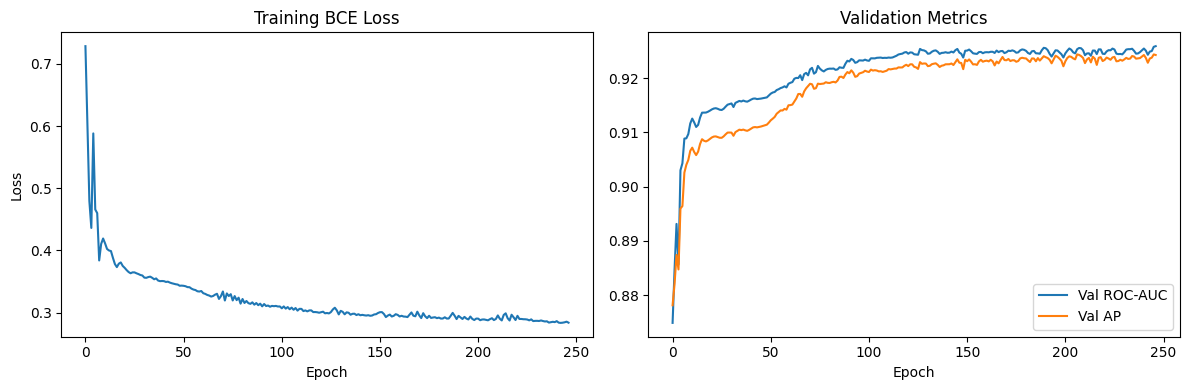

In [13]:
def edge_logits(node_embeddings, edges_tensor, predictor_model):
    src = node_embeddings[edges_tensor[:, 0]]
    dst = node_embeddings[edges_tensor[:, 1]]
    return predictor_model(src, dst)

@torch.no_grad()
def evaluate_split(encoder_model, predictor_model, node_features, adj, pos_edges, neg_edges):
    encoder_model.eval()
    predictor_model.eval()

    z = encoder_model(node_features, adj)
    pos_logits = edge_logits(z, pos_edges, predictor_model)
    neg_logits = edge_logits(z, neg_edges, predictor_model)

    scores = torch.sigmoid(torch.cat([pos_logits, neg_logits], dim=0)).cpu().numpy()
    labels = np.concatenate([
        np.ones(pos_logits.shape[0], dtype=np.int64),
        np.zeros(neg_logits.shape[0], dtype=np.int64)
    ])

    auc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)
    return auc, ap

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(predictor.parameters()),
    lr=1e-2,
    weight_decay=1e-4
)

num_epochs = 400
patience = 40
best_val_ap = -np.inf
epochs_without_improvement = 0
best_state = None

history = {'loss': [], 'val_auc': [], 'val_ap': []}

for epoch in range(1, num_epochs + 1):
    encoder.train()
    predictor.train()

    optimizer.zero_grad()
    z = encoder(x, adj_train)

    pos_logits = edge_logits(z, train_pos_t, predictor)
    neg_logits = edge_logits(z, train_neg_t, predictor)
    logits = torch.cat([pos_logits, neg_logits], dim=0)

    labels = torch.cat([
        torch.ones_like(pos_logits),
        torch.zeros_like(neg_logits)
    ], dim=0)

    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()

    val_auc, val_ap = evaluate_split(encoder, predictor, x, adj_train, val_pos_t, val_neg_t)

    history['loss'].append(float(loss.item()))
    history['val_auc'].append(float(val_auc))
    history['val_ap'].append(float(val_ap))

    if val_ap > best_val_ap:
        best_val_ap = val_ap
        epochs_without_improvement = 0
        best_state = {
            'encoder': copy.deepcopy(encoder.state_dict()),
            'predictor': copy.deepcopy(predictor.state_dict())
        }
    else:
        epochs_without_improvement += 1

    if epoch % 25 == 0 or epoch == 1:
        print(f'Epoch {epoch:03d} | Loss {loss.item():.4f} | Val AUC {val_auc:.4f} | Val AP {val_ap:.4f}')

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}. Best Val AP: {best_val_ap:.4f}')
        break

if best_state is not None:
    encoder.load_state_dict(best_state['encoder'])
    predictor.load_state_dict(best_state['predictor'])

test_auc, test_ap = evaluate_split(encoder, predictor, x, adj_train, test_pos_t, test_neg_t)
print(f'Final Test ROC-AUC: {test_auc:.4f}')
print(f'Final Test AP:      {test_ap:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history['loss'])
axes[0].set_title('Training BCE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(history['val_auc'], label='Val ROC-AUC')
axes[1].plot(history['val_ap'], label='Val AP')
axes[1].set_title('Validation Metrics')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.tight_layout()
plt.show()

### 7) Recommendation-Oriented Inference from Learned Link Scores

A practical interpretation of link prediction is candidate recommendation: for a source user, rank non-neighbors by predicted link probability. This cell demonstrates how to transform model outputs into actionable ranked suggestions for high-degree anchor nodes. We use the train graph neighborhood as the exclusion set, so recommended pairs are genuinely novel relative to observed training links.

In [14]:
@torch.no_grad()
def recommend_links_for_node(node_id, graph, encoder_model, predictor_model, node_features, adj, top_k=5):
    encoder_model.eval()
    predictor_model.eval()

    z = encoder_model(node_features, adj)
    neighbors = set(graph.neighbors(node_id))
    neighbors.add(node_id)

    candidates = [v for v in range(graph.number_of_nodes()) if v not in neighbors]
    src = torch.full((len(candidates),), int(node_id), dtype=torch.long, device=device)
    dst = torch.tensor(candidates, dtype=torch.long, device=device)

    scores = torch.sigmoid(predictor_model(z[src], z[dst])).cpu().numpy()
    order = np.argsort(scores)[::-1][:top_k]
    return [(int(candidates[i]), float(scores[i])) for i in order]

anchor_nodes = [node for node, _ in sorted(train_graph.degree(), key=lambda x: x[1], reverse=True)[:5]]
for node in anchor_nodes:
    recs = recommend_links_for_node(node, train_graph, encoder, predictor, x, adj_train, top_k=5)
    print(f'Node {node} top recommendations: {recs}')

Node 127 top recommendations: [(1476, 0.9999998807907104), (1660, 0.9999985694885254), (103, 0.9999808073043823), (1593, 0.9999276399612427), (1433, 0.9996272325515747)]
Node 1476 top recommendations: [(127, 0.9999998807907104), (467, 0.9999961853027344), (1660, 0.9999842643737793), (1320, 0.9999409914016724), (103, 0.999872088432312)]
Node 1297 top recommendations: [(103, 0.9998396635055542), (471, 0.9994572997093201), (428, 0.9991990923881531), (1721, 0.9990562796592712), (1739, 0.9990214109420776)]
Node 467 top recommendations: [(1476, 0.9999961853027344), (290, 0.999991774559021), (1320, 0.9999349117279053), (1721, 0.9991810917854309), (1739, 0.9991477727890015)]
Node 290 top recommendations: [(467, 0.999991774559021), (1758, 0.9998587369918823), (1721, 0.9987517595291138), (305, 0.9985430240631104), (287, 0.9982295632362366)]


#### Overview
- Takes your Twitch user graph and treats existing connections as examples of “real links.”
- Hides a portion of real links for validation/test, so the model must predict links it has not seen.
- Creates fake (non-existing) user pairs as negative examples, so the model learns link vs no-link.
- Builds node features from graph structure (degree, clustering, core score, PageRank) using only the training graph.
- Runs a GraphSAGE encoder to turn each user into an embedding that summarizes their neighborhood.
- Scores each user pair with a small neural scorer to estimate the probability that a link should exist.
- Trains with binary classification loss (link = 1, no link = 0), and uses validation performance to stop early.
- Reports test metrics (ROC-AUC, AP) and can rank top likely new connections as recommendations.